# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [465]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multinomial

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [466]:
ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X

        # parameters for normal distribution are mean and stdev
        self.mean = np.mean(X)
        variance = np.var(X)

        self.st_dev = np.sqrt(variance)

        if self.st_dev == 0:
            self.st_dev = 1e-6

        return self.mean, self.st_dev
        

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # log to avoid underflow issues
        return norm.logpdf(X_new, loc=self.mean, scale=self.st_dev)

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # parameter of Bernoulli distribution is p
        self.p = (sum(X) + ALPHA) / (len(X) + ALPHA * 2)
        # using Laplace smoothing to avoid zero probabilities that would strongly affect predictions
        return self.p


    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        return bernoulli.logpmf(X_new, self.p)

# Distribution for categorical features
class CatFeatureParam:
    
    # number of categories for the categorical feature
    def __init__(self, nr_categories):
        self.nr_categories = nr_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        self.p_vector = []
        for i in range(self.nr_categories):
            pi = (sum(X == i) + ALPHA) / (len(X) + ALPHA * self.nr_categories)
            self.p_vector.append(pi)
        return self.p_vector # vector of probabilities pi where each value is the prob of having category i
        
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # N = 1 for multinoulli
        probs = []
        X = [0 for a in range(self.nr_categories)] # array initialized with as many zeros as the number of categories
        for record in X_new:
            X[record] = 1 # the index i is 1 since we have the category i been applied
            prob = multinomial.logpmf(X, 1, np.array(self.p_vector)).item()
            X = [0 for a in range(self.nr_categories)]
            probs.append(prob)
        return probs
        

**Tests:**
    
We will use the code below to test the correctness of your code.

In [467]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [468]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [469]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(nr_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.9459101490553135, -2.169053700369523, -1.9459101490553135, -2.456735772821304, -2.169053700369523, -2.8622008809294686, -1.9459101490553135, -3.5553480614894135, -2.169053700369523, -2.862200880929468]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [470]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[], num_cat=None):
        self.feature_types = feature_types
        self.num_cat = num_cat

    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        N = len(X)
        self.classes = np.unique(y)

        if self.num_cat != None:
            nr_categories = self.num_cat

        else:
            nr_categories = []

            for col in range(X.shape[1]):
                if self.feature_types[col] == 'c':
                    single_col_X = X[:, col]
                    nr_categories.append(max(single_col_X) + 1)
                else:
                    nr_categories.append("0")
        
        X_split = {} # dictionary to split the data according to the category y

        classes_occ = {} # occurrences of each class
        self.classes_p = {} # probability of each class
        self.features = {} # store feature
        self.theta = {} # storing parameters for each class for each feature

        for c in self.classes:
            X_split[c] = X[y==c]
            classes_occ[c] = len(X_split[c])
            self.classes_p[c] = classes_occ[c] / N
            self.theta[c] = {}
            self.features[c] = {}

            for col in range(X.shape[1]):
                counter = 0
                X_col = X_split[c][:,col]  #all rows but just one col at the time
                # check the type of the col and estimate the parameters accordingly
                if self.feature_types[col] == "r":
                    self.features[c][col] = ContFeatureParam()
                    self.theta[c][col] = self.features[c][col].estimate(X_col)
                    counter += 1
                if self.feature_types[col] == "b":
                    self.features[c][col] = BinFeatureParam()
                    self.theta[c][col] = self.features[c][col].estimate(X_col)
                    counter += 1
                if self.feature_types[col] == "c":
                    self.features[c][col] = CatFeatureParam(nr_categories[col])
                    self.theta[c][col] = self.features[c][col].estimate(X_col)
                    counter += 1
        return self.theta, self.classes_p # returning the estimated parameters and the probability of each class
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        prob_data_class = {}
        for c in self.classes:
            prob_data_class[c] = np.log(self.classes_p[c])
            for col in range(X.shape[1]):
                X_col = X[:, col]
                p = self.features[c][col].get_log_probability(X_col) # prob of a specific data point to belong to a specific class
                prob_data_class[c] += p  # sum because of log

        # cpmputing classes which max prob for each data point
        c_max = []
        for point in range(X.shape[0]):
            probs = []
            for c in prob_data_class.keys():
                probs.append(prob_data_class[c][point])
            c_max.append(probs.index(max(probs)))

        return c_max


In [471]:
hola = np.array([3, 1, 2, 1, 2, 4, 4, 3, 3, 3, 1, 1, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2,
       1, 2, 1, 4, 2, 2, 3, 3, 2, 1, 2, 1, 2, 3, 4, 3, 2, 1, 2, 2, 3, 4,
       2, 3, 2, 2, 2, 3, 5, 2, 2, 2, 3, 2, 1, 4, 4, 4, 3, 3, 4, 3, 3, 1,
       3, 2, 4, 2, 2, 3, 2, 3, 2, 1, 4, 2, 3, 3, 2, 2, 3, 4, 3, 3, 3, 4,
       2, 3, 3, 3, 3, 3, 1, 2, 4, 2, 2, 2, 2, 4, 2, 3, 4, 5, 3, 2, 5, 3,
       3, 2, 4, 4, 1, 3, 3, 2, 2, 3, 4, 3, 4, 3, 4, 1, 4, 2, 4, 2, 3, 3,
       2, 3, 3, 2, 3, 4, 2, 1, 3, 2, 2, 3, 1, 3, 5, 4, 2, 3, 3, 3, 3, 3,
       2, 2, 3, 2])

np.unique(hola)
len(np.unique(hola))

5

**Tests**

We will use the code below to check your code.

In [472]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)



Accuracy: 0.9333333333333333
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [473]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./data/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


In [474]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./data/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1] # all except last
y = data[:,-1] # just last

#splitting into train and test
N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat)

Accuracy: 0.6896551724137931
[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [475]:
from sklearn.linear_model import LogisticRegression
from warnings import simplefilter
simplefilter(action='ignore')

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [476]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):

    N, D = X.shape
    Ntrain = int(0.8 * N)

    tst_errs_nbc = []
    tst_errs_lr = []

    for split in range(1, num_splits+1):
        test_err_nbc_split = [0]*num_splits
        test_err_lr_split = [0]*num_splits
        for run in range(num_runs):
            shuffler = np.random.permutation(N)
            Xtrain = X[shuffler[:Ntrain]]
            ytrain = y[shuffler[:Ntrain]]
            Xtest = X[shuffler[Ntrain:]]
            ytest = y[shuffler[Ntrain:]]

            Ntrain_split = int(split/num_splits * Ntrain)
            Xtrain_split = Xtrain[:Ntrain_split]
            ytrain_split = ytrain[:Ntrain_split]

            #NBC
            nbc.fit(Xtrain_split, ytrain_split)
            yhat = nbc.predict(Xtest)
            test_err_nbc_split.append(1 - np.mean(yhat == ytest))
            
            #LR
            clf = lr.fit(Xtrain_split, ytrain_split)
            test_err_lr_split.append(1 - clf.score(X, y))
        
        tst_errs_nbc.append(np.mean(test_err_nbc_split))
        tst_errs_lr.append(np.mean(test_err_lr_split))

    return tst_errs_nbc, tst_errs_lr

In [477]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. Prepare the data for the two classifiers, e.g., handle missing values and the categorical data. When you handle the categorical data, you should check whether the data is ordinal or not. If the data is ordinal, you should encode the data as integers. If the data is not ordinal, you should encode the data as one-hot vectors.
2. Show the first 5 rows of the prepared data
3. Compare the two classifiers on the dataset and generate the plots

The grading will be based on whether the data is correctly prepared and the plots are generated without errors. The grading will not be based on the performance of the classifiers and whether the plots are the same as in the paper. 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [478]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()

X, y = iris.data, iris.target
print(X.shape)
print("Number of classes:", len(set(y)))
print(iris.feature_names) # all the attributes are numerical



(150, 4)
Number of classes: 3
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


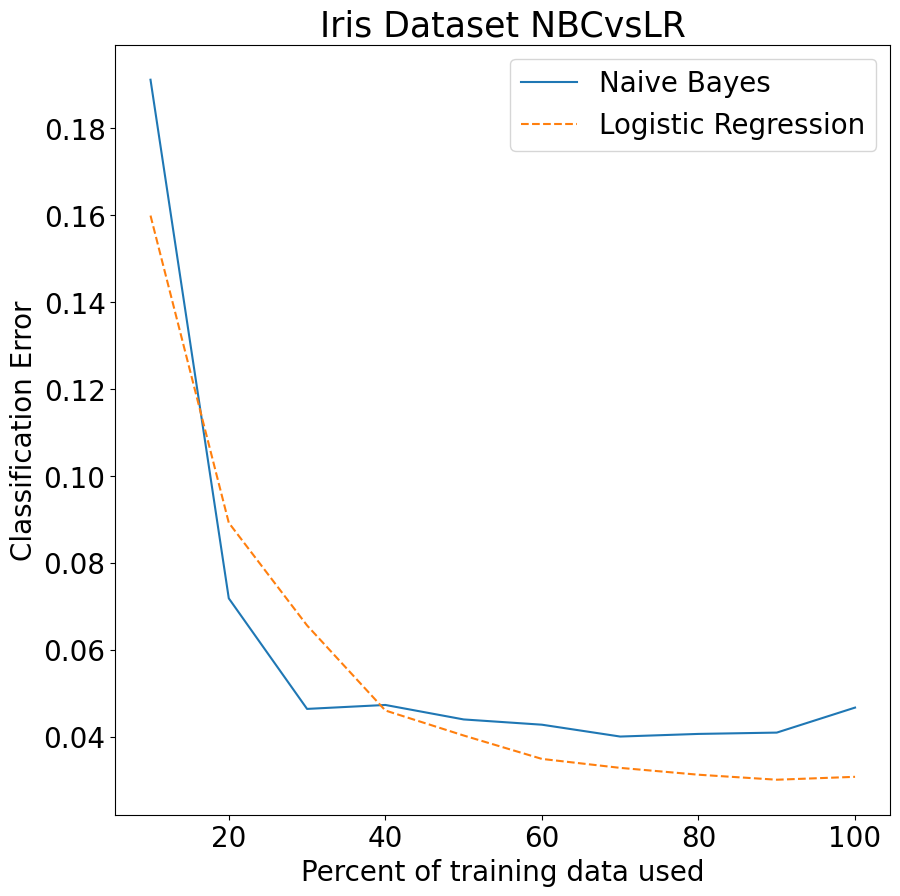

In [479]:
# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Compare and plot
nbc = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression(random_state=0)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y, num_runs=100, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="Iris Dataset NBCvsLR", num_splits=10)

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. 

In [480]:
# load the dataset
voting = pd.read_csv('./data/voting.csv')

voting.info()
voting.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

(435, 17)

In [481]:
voting.head()

,label,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [482]:
# Data preparation
voting.dropna(axis=0, inplace=True)
voting.replace({'n': 0, 'y': 1}, inplace=True)
voting.replace({'republican': 0, 'democrat': 1}, inplace=True)
voting.head()

,label,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
5,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
8,0,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
19,1,1,1,1,0,0,0,1,1,1,0,1,0,0,0,1,1
23,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1,1
25,1,1,0,1,0,0,0,1,1,1,1,0,0,0,0,1,1


In [483]:
set(voting["label"])

{0, 1}

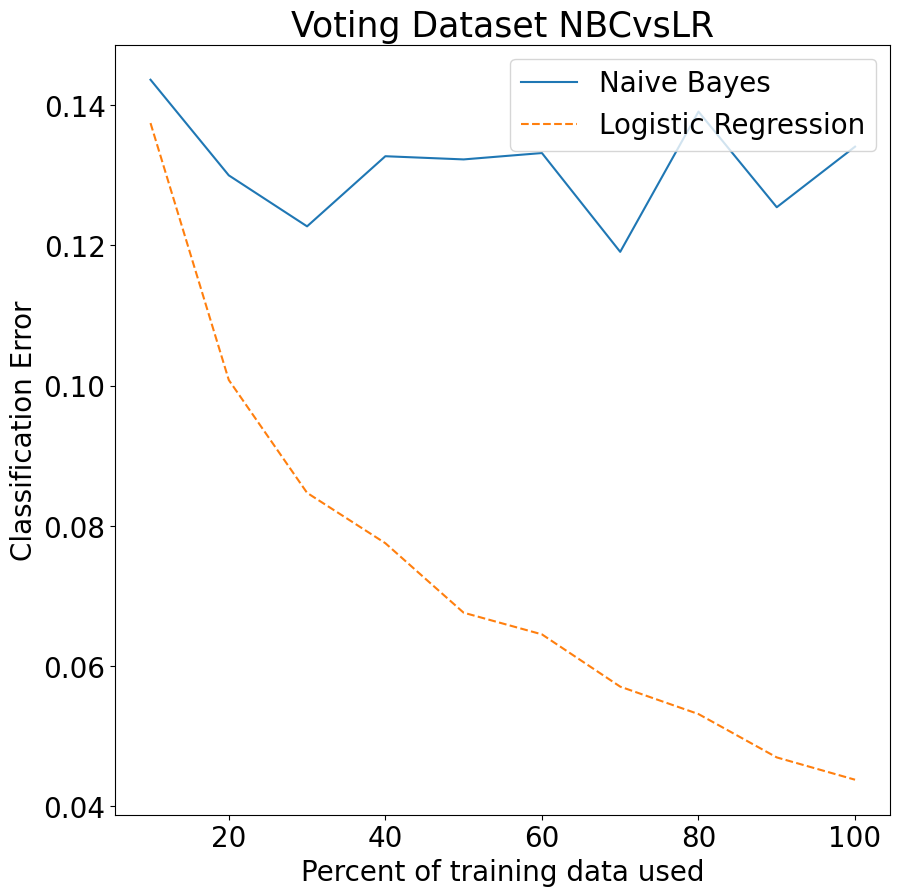

In [484]:
success = False # introducing while loop to make sure the cell runs until it does not return an error

while not success:
    try:

        # Select sample making sure it contains all the classes
        categories = set(voting["label"])
        sample_cat = set()

        while len(sample_cat) < 2:
            sample = voting.sample(n= 100)
            sample_cat = set(sample["label"])

        # Split X and y
        X = sample.loc[:, sample.columns != "label"].to_numpy()
        y = sample["label"].to_numpy()

        # Compare and plot
        nbc = NBC(feature_types=['b'] * X.shape[1])
        lr = LogisticRegression(random_state=0)

        tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y, num_runs=100, num_splits=10)
        makePlot(tst_errs_nbc, tst_errs_lr, title="Voting Dataset NBCvsLR", num_splits=10)

        success = True

    except ValueError as e:
        print("")

**Dataset 3: Breast Cancer Dataset (Bonus Tasks)**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

The dataset has continues, binary and categorical features. It also has missing values.

Hints: You can precompute the size of the domains of the categorical features.

In [485]:
cancer = pd.read_csv('./data/breast-cancer.csv')

cancer.info()
cancer.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


(286, 10)

In [486]:
cancer.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [487]:
# checking numerical attributes
cancer.describe()

,deg-malig
count,286.000000
mean,2.048951
std,0.738217
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [488]:
# checking categorical attributes
cancer.describe(include=object)

,Class,age,menopause,tumor-size,inv-nodes,node-caps,breast,breast-quad,irradiat
count,286,286,286,286,286,286,286,286,286
unique,2,6,3,11,7,3,2,6,2
top,no-recurrence-events,50-59,premeno,30-34,0-2,no,left,left_low,no
freq,201,96,150,60,213,222,152,110,218


In [489]:
# dropping missing values
cancer = cancer[cancer['node-caps'] != "?"]  
cancer = cancer[cancer['breast-quad'] != "?"]

In [490]:
# Dealing with categorical ordinal attributes
cancer["Class"].replace({'no-recurrence-events': 0, 'recurrence-events': 1}, inplace=True)
cancer["age"].replace({'20-29': 0, '30-39': 1, '40-49': 2, '50-59': 3, '60-69': 4, '70-79': 5, '80-89': 6, '90:99':7}, inplace=True)
cancer["menopause"].replace({'lt40': 0, 'premeno': 1, 'ge40': 2}, inplace=True)
cancer["tumor-size"].replace({'0-4': 0, '5-9': 1, '10-14': 2, '15-19': 3, '20-24': 4, '25-29': 5, '30-34': 6, '35-39': 7, '40-44': 8, '45-49': 9, '50-54': 10, '55-59': 11}, inplace=True)
cancer["inv-nodes"].replace({'0-2': 0, '3-5': 1, '6-8': 2, '9-11': 3, '12-14': 4, '15-17': 5, '18-20': 6, '21-23': 7, '24-26': 8, '27-29': 9, '30-32': 10, '33-35': 11, '36-39': 12}, inplace=True) # weird two intermediate categories missing
cancer["node-caps"].replace({'no': 0, 'yes': 1}, inplace=True) 
cancer["breast"].replace({'left': 0, 'right': 1}, inplace=True)
cancer["irradiat"].replace({'no': 0, 'yes': 1}, inplace=True)
cancer["deg-malig"].replace({1:0, 2:1, 3:2}, inplace=True)

# breast-quad is not ordinal use one-hot encording
cancer = pd.get_dummies(cancer, columns=["breast-quad", ])
cancer = cancer.astype(int)
cancer

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,irradiat,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,0,1,1,6,0,0,2,0,0,0,1,0,0,0
1,0,2,1,4,0,0,1,1,0,0,0,0,0,1
2,0,2,1,4,0,0,1,0,0,0,1,0,0,0
3,0,4,2,3,0,0,1,1,0,0,0,1,0,0
4,0,2,1,0,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,1,1,6,0,0,1,0,0,0,0,1,0,0
282,1,1,1,4,0,0,2,0,1,0,0,1,0,0
283,1,4,2,4,0,0,0,1,0,0,0,1,0,0
284,1,2,2,6,1,0,2,0,0,0,1,0,0,0


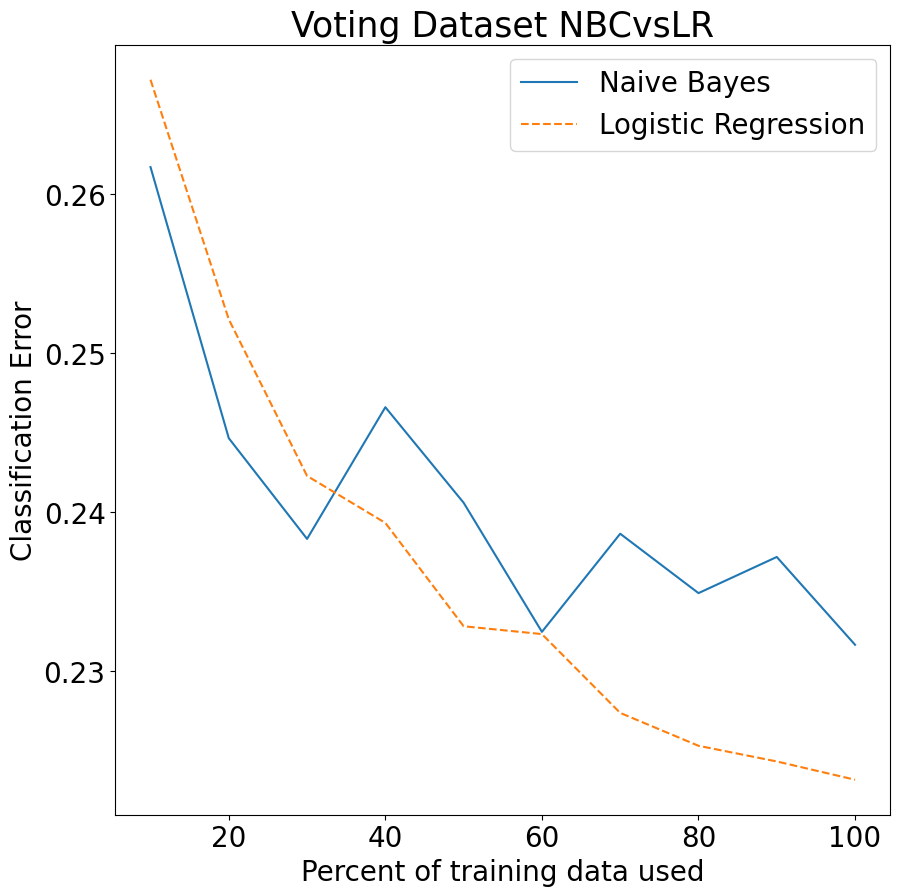

In [491]:
# Split X and y
X = cancer.loc[:, cancer.columns != "Class"].to_numpy()
y = cancer["Class"].to_numpy()


# Compare and plot
nbc = NBC(feature_types=['c', 'c', 'c', 'c', 'b', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b'], num_cat=[8, 3, 12, 13, 0, 3, 0, 0, 0, 0, 0, 0, 0])
lr = LogisticRegression(random_state=0)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y, num_runs=100, num_splits=10)
makePlot(tst_errs_nbc, tst_errs_lr, title="Voting Dataset NBCvsLR", num_splits=10)